In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import matplotlib.pyplot as plt
import genjax
import jax
import jax.numpy as jnp 
from b3d.utils import keysplit
from b3d.camera import Intrinsics, screen_from_camera
from b3d.pose import Pose, camera_from_position_and_target
from b3d.gps_utils import cov_from_dq_composition
from b3d.pose_utils import uniform_pose


key = jax.random.PRNGKey(0)

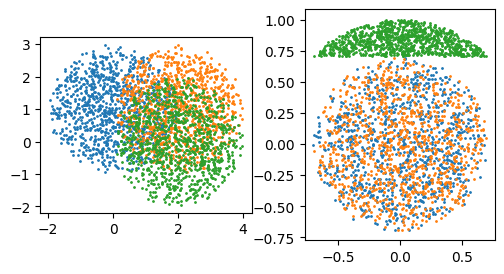

In [11]:
key, keys = keysplit(key, 1, 1_000)
p0 = Pose.from_pos(jnp.array([0.,1.,2.]))
ps = jax.vmap(uniform_pose.sample, (0,None,None,None))(keys, p0, 2., 0.5)
# ===========================================
fig, axs = plt.subplots(1,2,figsize=(6,3))
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')
axs[0].scatter(ps.pos[:,0], ps.pos[:,1], s=1)
axs[0].scatter(ps.pos[:,2], ps.pos[:,1], s=1)
axs[0].scatter(ps.pos[:,2], ps.pos[:,0], s=1)
axs[1].scatter(ps.quat[:,0], ps.quat[:,1], s=1)
axs[1].scatter(ps.quat[:,2], ps.quat[:,1], s=1)
axs[1].scatter(ps.quat[:,2], ps.quat[:,3], s=1)

In [13]:
from b3d.gps_utils import add_dummy_var

p0 = Pose.identity()
args = (p0, 2., 0.5)
dummy_mapped_uniform_pose = genjax.map_combinator(in_axes=(0,None,None,None))(add_dummy_var(uniform_pose))

dummy_mapped_uniform_pose.simulate(key, (jnp.arange(4), *args));

In [5]:
from b3d.sparse_hgps_model import make_sparse_gps_model
from hgps.sparse_gps_observation_model import (
    make_sparse_observation_model,
    make_sparse_explicit_observation_model
)


help(make_sparse_gps_model)

Help on function make_sparse_gps_model in module hgps.sparse_gps_model:

make_sparse_gps_model(T, N, K, F, particle_pose_prior, particle_pose_prior_args, object_pose_prior, object_pose_prior_args, camera_pose_prior, camera_pose_prior_args, observation_model, observation_model_args, object_motion_model, object_motion_model_args, camera_motion_model, camera_motion_model_args)
    Models independently moving rigid object as clusters of
    Gaussians which specify the position, pose, and uncertainty of 3d keypoints in space.
    
    For simplicity we assume that keypoints can only emit a single constant feature,
    that we may interpret as a "point light".
    
    We can easily extend this model to handle feature vectors.
    
    Args:
        `T`: Number of time steps
        `N`: Number of particles
        `K`: Number of object clusters
        `F`: Feature dimension
        `particle_pose_prior`: Particle pose model `(nums: Array, *args) -> poses`.
        `particle_pose_prior_args

In [75]:
intr = Intrinsics(100, 50, 100., 100., 50., 25., 1e-6, 100.)
outlier_prob = 0.0


p0 = Pose.identity()
particle_pose_prior = dummy_mapped_uniform_pose
particle_pose_prior_args = (p0, .5, 0.25)

object_pose_prior = dummy_mapped_uniform_pose
object_pose_prior_args = (p0, 2., 0.5)

camera_pose_prior = uniform_pose
camera_pose_prior_args = (p0, 0.1, 0.1)

observation_model = make_sparse_explicit_observation_model()
observation_model_args = (outlier_prob, )


object_motion_model = genjax.map_combinator(in_axes=(0,None,None))(uniform_pose)
object_motion_model_args = (0.1, 0.1)

camera_motion_model = uniform_pose
camera_motion_model_args = (0.1, 0.2)

In [76]:
T,N,K = 2, 3, 3
F = 0
maker_args = (
    T,N,K,F,
    particle_pose_prior,
    particle_pose_prior_args,
    object_pose_prior,
    object_pose_prior_args,
    camera_pose_prior,
    camera_pose_prior_args,
    observation_model,
    observation_model_args,
    object_motion_model,
    object_motion_model_args,
    camera_motion_model,
    camera_motion_model_args,
)
model = make_sparse_gps_model(*maker_args)
jimportance = jax.jit(model.importance)

In [77]:
from genjax import Selection as Sel, ChoiceMap as C

chm = genjax.choice_map({ 
    "chain": genjax.vector_choice_map(
        genjax.choice_map({"observation": 
            genjax.vector_choice_map({
                "index": jnp.tile(jnp.arange(N), (T-1,1))
            })
        })
    )
})
key = keysplit(key)
tr,w = jimportance(key, chm, (intr,));

In [139]:
from typing import Any, TypeAlias
from hgps.dynamic_gps import DynamicGPS
SparseGPSModelTrace: TypeAlias = Any


def get_inner_val(tr, addr, *rest):
    """Hack till PR is merged."""
    inner_val = None
    if hasattr(tr[addr], "inner"):
        if hasattr(tr[addr].inner, "value"):
            inner_val = tr[addr].inner.value
        else:
            inner_val = tr[addr].inner
    else: 
        inner_val = tr[addr]

    if len(rest) == 0:
        return inner_val
    else:
        return get_inner_val(inner_val, *rest)


def get_particles(tr: SparseGPSModelTrace):
    """Returns the particle poses, covariances, and features from a SparseGPSModelTrace."""
    return (get_inner_val(tr,"particle_poses"), tr["particle_jitter"], tr["particle_features"])        


def get_assignments(tr: SparseGPSModelTrace):
    return get_inner_val(tr, "object_assignments")


def get_object_poses(tr: SparseGPSModelTrace):
    return get_inner_val(tr,"initial_object_poses")[None, :].concat(
        get_inner_val(tr, "chain", "object_poses"), axis=0
    )


def get_cameras(tr: SparseGPSModelTrace):
    return get_inner_val(tr, "initial_camera_pose")[None, :].concat(get_inner_val(tr,"chain","camera_pose"))


def get_2d_particle_positions(tr: SparseGPSModelTrace):
    return jnp.concatenate(
        [
            get_inner_val(tr,"initial_observation", "2d_particle_position")[None],
            get_inner_val(tr,"chain", "observation", "2d_particle_position"),
        ],
        axis=0,
    )


def get_dynamic_gps(tr: SparseGPSModelTrace):
    """Gets the DynamicGPS object from a SparseGPSModelTrace."""
    return DynamicGPS.from_pose_data(
        *get_particles(tr), get_assignments(tr), get_object_poses(tr)
    )

In [137]:
get_object_poses(tr)
get_object_poses(tr)
get_cameras(tr)
get_2d_particle_positions(tr)

Array([[[ 207.79166 ,  -61.353302],
        [2411.2766  ,  163.68176 ],
        [-148.59624 , -162.10228 ]],

       [[1364.1478  , 1532.8999  ],
        [-298.5125  ,  -31.428455],
        [ 820.4798  , -484.755   ]]], dtype=float32)

In [142]:
gps    = get_dynamic_gps(tr)
cams   = get_cameras(tr)
obs2d  = get_2d_particle_positions(tr)

rgb_imgs = jnp.zeros((T, intr.height, intr.width, 3))

In [8]:
# key = keysplit(key)
# tr,w = jimportance(key, genjax.choice_map({"particle_features": jnp.zeros((N,0)), }), (intr,));

In [30]:
# from hgps.sparse_gps_model import get_dynamic_gps, get_cameras, get_particles, get_2d_particle_positions

# gps    = get_dynamic_gps(tr)
# cams   = get_cameras(tr)
# colors = gps.random_color_by_cluster(key)
# obs    = get_2d_particle_positions(tr)

In [146]:
# from hgps.viz import create_matplotlib_gps_animation
# import numpy as np

# create_matplotlib_gps_animation(
#     "./_ani.gif", 
#     gps, cams, colors,
#     bb=np.array([[-2.5, 2.5], [-2.5, 2.5], [-2.5, 2.5]]).T)

'./_ani.gif'

In [42]:
# from hgps.feature_track_data import FeatureTrackData

# gps    = get_dynamic_gps(tr)
# cams   = get_cameras(tr)
# pos2d  = get_2d_particle_positions(tr)
# T = gps.num_timesteps

# FeatureTrackData(
#     latent_keypoint_positions    = gps.absolute_particle_poses.pos,
#     latent_keypoint_quaternions  = gps.absolute_particle_poses.quat,
#     observed_keypoints_positions = pos2d,
#     observed_features = jnp.zeros((T,0)),
#     rgb_imgs = jnp.zeros((T,0,0,3)),
#     oid_imgs = jnp.zeros((T,0,0)),
#     keypoint_ids = jnp.arange(N),
#     camera_position   = cams.pos,
#     camera_quaternion = cams.quat,
#     camera_intrinsics = intr.as_array()
# ).save("_data.npz")

In [39]:
# data = FeatureTrackData.load("_data.npz")

In [ ]:

# objs = gps.cluster_poses
# particles = gps.absolute_particle_poses
# idxs = gps.cluster_assignments

# N = gps.num_particles

# for i in range(N):
#     ax.plot(
#         [objs.pos[t, idxs[i], 0], particles.pos[t, i, 0]],
#         [objs.pos[t, idxs[i], 1], particles.pos[t, i, 1]],
#         [objs.pos[t, idxs[i], 2], particles.pos[t, i, 2]],
#         linewidth=0.5,
#         color=np.array(colors[i]),
#         alpha=0.5,
#     )

# ax.scatter(
#     particles.pos[t, :, 0],
#     particles.pos[t, :, 1],
#     particles.pos[t, :, 2],
#     c=colors,
#     marker="o",
# )

# ax.scatter(cams.pos[t, 0], cams.pos[t, 1], cams.pos[t, 2], c="r", marker="^")
# ax.axes.set_xlim3d(left=bb[0, 0], right=bb[1, 0])
# ax.axes.set_ylim3d(bottom=bb[0, 1], top=bb[1, 1])
# ax.axes.set_zlim3d(bottom=bb[0, 2], top=bb[1, 2])

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")

